In [7]:
import cv2
import time
import numpy as np
import logging
import math
import copy
from pathlib import Path
import json
from dataclasses import dataclass

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

from image_processing_lib import *


In [2]:
#external code not changed

@dataclass
class ChoiceBox:  #v1.5 changes
    cnum: int = -1
    area: float = 0.0
    w: int = 0
    h: int = 0
    cX: int = -1
    cY: int = -1
    angle: float = 180.
    parent: int = -1
    column: int = -1
    contest_num: int = -1
    candidate_name: str = ""
    contest_name: str = ""
    votes_allowed: int = -1
    error_score: float = 0
    contest_type = "" #should be either "regular" or "proposition"

#the lines are about 8-9 pixels wide
ACTUAL_CHOICE_BOX_WIDTH = 100 #what about thickness of lines??
ACTUAL_CHOICE_BOX_HEIGHT = 54
INNER_CHOICE_BOX_WIDTH = 80
INNER_CHOICE_BOX_HEIGHT = 34

def calc_choice_box_scoring_coords(choice_box_center_x, choice_box_center_y):
    
    #w2 = int(ACTUAL_CHOICE_BOX_WIDTH / 2) #cols -> x axis
    #h2 = int(ACTUAL_CHOICE_BOX_HEIGHT / 2) #rows -> y axis
    
    #ul_x = choice_box_center_x - w2 + CHOICE_BOX_COUNT_INSET
    #ul_y = choice_box_center_y - h2 + CHOICE_BOX_COUNT_INSET
    #lr_x = choice_box_center_x + w2 - CHOICE_BOX_COUNT_INSET
    #lr_y = choice_box_center_y + h2 - CHOICE_BOX_COUNT_INSET
    
    w2 = int(INNER_CHOICE_BOX_WIDTH / 2) #cols -> x axis
    h2 = int(INNER_CHOICE_BOX_HEIGHT / 2) #rows -> y axis
    
    ul_x = choice_box_center_x - w2 + 4
    ul_y = choice_box_center_y - h2 + 4 #try without this nudge + 2 #nudge this down a bit - seems to work better
    lr_x = choice_box_center_x + w2 - 4
    lr_y = choice_box_center_y + h2 - 4
    
    return ul_x, ul_y, lr_x, lr_y

def align_form_and_update_CB_locations(img, img_template, choices_dict, bscanner):
    #img = form, img_template = template for form (used only for debugging)
    #processing a new ballot (img) with choice_dict from reference template
    #goal is to update choices_dict to have actual cX, cY offsets of this ballot, rather than the template reference ballot
    #uses a combination of contour-mapping and template-matching to locate ALL choicesboxes, based on reference ballot

    #first, clone the template's choices_dict so we can update it with this form's actual CB locations.
    #be careful NOT to mess with the template's choices_dict
    print("entered align_form 3")
    cloned_choices_dict = copy.deepcopy(choices_dict)

    #then, vertically align form and shift x,y to "standard" position from top left
    aligned_form_image, affine_M = align_form_using_barcode_stripes(img, bscanner.form_path)

    #debug_display_images((img,'before align'),(aligned_form_image, 'after align'))

    #first find as many CB contours as possible
    temp_gray = cv2.cvtColor(aligned_form_image, cv2.COLOR_BGR2GRAY)
    _, temp_binary = cv2.threshold(temp_gray, 127, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(temp_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    #these need to be very selective and not overly sensitive, so use tight parameters
    #fixme - convert to global parameters about this class of forms?
    
    MAX_CHOICE_BOX_WIDTH = 160
    MAX_CHOICE_BOX_HEIGHT = 100
    MIN_CHOICE_BOX_WIDTH = 85
    MIN_CHOICE_BOX_HEIGHT = 50

    COLUMN_HALF_WIDTH_FOR_CHOICEBOX_SEARCH = 100
    TEMPLATE_MATCH_THRESHOLD = 0.7  #using checkerboard pattern requires this to be fairly low
    
    MIN_AREA = 5000
    MAX_AREA = 5400

    results = []

    start = time.time()

    print(f"found {len(contours)} comtours")
    for cnum, cnt in enumerate(contours):

        area = cv2.contourArea(cnt)
        
        #set a tight constraint - we can afford to miss a few, but a false-positive is bad
        if area >= MIN_AREA and area <= MAX_AREA:

            x,y,w,h = cv2.boundingRect(cnt)
            if (w < MIN_CHOICE_BOX_WIDTH or w > MAX_CHOICE_BOX_WIDTH) or \
                (h < MIN_CHOICE_BOX_HEIGHT or h > MAX_CHOICE_BOX_HEIGHT) :
                #print("warning {} rejecting contour={} - box width {} a/or height {} with area {} out of range".format(form_name_path.stem, cnum, w, h, area))
                continue

            M = cv2.moments(cnt)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
                        
            #use choicebox as convenient way to name and hold stuff tho these get replaced later with "real" CB
            cb = ChoiceBox()
            cb.cnum = cnum
            cb.area = area
            cb.cX = cX
            cb.cY = cY

            results.append(cb)
    
    #now match reference choiceboxes to the CB we found on the form
    #build linear list of CB, counting on shallow copy to permit updates to go deeper
    unmatched_CB  = [cb for contest in cloned_choices_dict['contests'] for cb in contest['choice_boxes']]
    updated = [False for cb in unmatched_CB]  #track which ones we have done
    
    print(f"contour matching found {len(results)} CB on ballot")
    logging.debug(f"form:{bscanner.form_path.name} contour-matching found {len(results)} CB on ballot")
    print(f"choices dict has {len(unmatched_CB)} CB to be updated")
    logging.debug(f"form:{bscanner.form_path.name} template dict has {len(unmatched_CB)} CB to be updated")

    #changed to 70 after some very skewed forms failed at 50
    #no, leave at 50 for now.
    CLOSE_ENOUGH = 50 #70 seems to be able to handle difference between "v1" and "v2" versions of same precinct-page

    dist = lambda f, r: np.sqrt( (f.cX - r['cX'])**2 + (f.cY - r['cY'])**2   )
    distances = []
    x_gaps = [] #measured from FORM to TEMPLATE
    y_gaps = []

    #find closest one
    best_d = 100000000
    best_i = -1
    best_r_cb = None

    for f_cb in results: #the ballot form
        for i, r_cb in enumerate(unmatched_CB):  #the reference template
            if updated[i] == False:  #only consider unmatched template reference CBs
                d = dist(f_cb, r_cb)
                if d < best_d:
                    best_d = d
                    best_i = i
                    best_r_cb = r_cb
        #have best choice here so update reference CB with actual CB (reference will be stored with output JSON)
        if best_d < CLOSE_ENOUGH:
            print(f"best distance was {best_d} - so updating reference CB {best_r_cb['cX']}, {best_r_cb['cY']} with actual CB {f_cb.cX}, {f_cb.cY}")
            x_gaps.append(best_r_cb['cX'] - f_cb.cX)
            y_gaps.append(best_r_cb['cY'] - f_cb.cY)
            best_r_cb['cX'] = f_cb.cX
            best_r_cb['cY'] = f_cb.cY
            #and flag as updated
            updated[best_i] = True
            distances.append(best_d)
            best_d = 10000000 
        else:
            distances.append(best_d)
            print(f"closest distance {best_d} was too far - contours can't map #{best_i}")       
            logging.debug(f" Form:{bscanner.form_path.name} - closest distance: {best_d} was too far - contours can't map point #{best_i}")
    
    #at this point, only CB that were not found by contours remain updated == False
    to_do_count = len( [item for item in updated if item == False] )
    print(f"After contour matching, {to_do_count} CB remained unmatched")
    logging.debug(f"form:{bscanner.form_path} After contour matching {to_do_count} CB remained unmatched - now try template-sliding")
    #print(f"x-gaps = {x_gaps}")
    #print(f"y-gaps = {y_gaps}")

    #for each remaining un-updated CB, we will search using template-matching
    
    cbtm = ChoiceBoxTemplateMatcher(bscanner.metadata)

    #use x and y gaps to "hedge" the search since presumably the form is linearly shifted for some reason
    if len(x_gaps) > 0 and len(y_gaps) > 0:
        avg_x_gap = np.mean(np.array(x_gaps))
        avg_y_gap = np.mean(np.array(y_gaps))
    else:
        avg_x_gap = 0
        avg_y_gap = 0

    for i, cb in enumerate(unmatched_CB):
        if updated[i] == True:
            continue
        
        #coordinates of area to search - just around where we expected the CB to be, from metadata
        SEARCH_RANGE_WIDE = 100 #search window has to be bigger than the template
        SEARCH_RANGE_HIGH = 60 #needs to be tighter going up/down to avoid finding adjacent CB

        #gaps are measured from Template to Form so a positive gap is substracted from our search center point
        search_cX = cb['cX'] - int(avg_x_gap)
        search_cY = cb['cY'] - int(avg_y_gap)

        found = cbtm.search_for_choiceboxes(-1, aligned_form_image, search_cX-SEARCH_RANGE_WIDE, search_cY-SEARCH_RANGE_HIGH,
                                                search_cX+SEARCH_RANGE_WIDE, search_cY+SEARCH_RANGE_HIGH, TEMPLATE_MATCH_THRESHOLD)
        if len(found) == 0:
            print(f"OOPS - template match for {cb} found NO template!!")
            #fix me = add loop to select closest one!
            logging.debug(f"form: {bscanner.form_path.name} template match found NO template match for a choicebox!")            
        elif len(found) > 1:
            print(f"OOPS - template match for {cb} found MORE than one templates for choicebox. Found: {len(found)} templates")
            #print(f"searching for :{cb} found first: {found[0]} second:{found[1]}")
            logging.debug(f"form: {bscanner.form_path.name} template match found more than 1 match. Skipping this choicebox!")
        else:
            #got a single good match so update the reference CB with the found coordinates
            cbi = found[0]
            d = dist(cbi, cb)
            print(f"distance: {d}  - updating reference CB {cb['cX']}, {cb['cY']} with actual CB {cbi.cX}, {cbi.cY}")
            if d > CLOSE_ENOUGH:
                logging.warning(f" Form:{bscanner.form_path.name} - assigned template match for {cb['cX']},{cb['cY']} was FARTHER than expected: {d} - review form!")
            cb['cX'] = int(cbi.cX)
            cb['cY'] = int(cbi.cY)
            updated[i] = True
            distances.append(d)

    avg_distance = np.mean(np.array(distances))
    logging.debug(f" Form:{bscanner.form_path.name} - Average distance for choicebox correction was {avg_distance}")
    
    #at this point, all CB in the reference template should be updated
    #if not, then we can try the homology approach, which uses different assumptions
    to_do_count = len( [item for item in updated if item == False] )
    #print(f"Verify - After contour matching, {to_do_count} CB remained unmatched")

    #fixme add to image logger
    #debug_show_stuff(img_template, img, aligned_form_image, choices_dict, cloned_choices_dict)
    
    if to_do_count > 0:
        print(f" Form:{bscanner.form_path.name} - UNABLE to match all choiceboxes between form and reference - left over = {to_do_count} Will try Homology next")
        logging.warning(f"Form:{bscanner.form_path.name} - Contour/slide-template failed to find all choiceboxes. Leftover = {to_do_count}")
        logging.warning(f"Form:{bscanner.form_path.name} - Will fall-back and try Homology mapping - please verify results")
        return  None, None, "", None #return Nones to signal contour/slide-template failure

    return  aligned_form_image, affine_M, "", cloned_choices_dict #return the aligned form and the updated copy of choices_dict

class ChoiceBoxTemplateMatcher():
    def __init__(self, metadata):
        self.metadata = metadata
        #temp_img = cv2.imread("one_choicebox.jpg")
        #temp_gray = cv2.cvtColor(temp_img, cv2.COLOR_BGR2GRAY)
        #self.open_template_binary = cv2.threshold(temp_gray, 127, 255, 
    
        temp_gray = cv2.cvtColor(self.metadata.checkerboard_match_template_image, cv2.COLOR_BGR2GRAY)
        self.checkerboard_template_binary = cv2.threshold(temp_gray, 127, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
        self.th, self.tw = self.checkerboard_template_binary.shape # .shape returns (rows, cols)
        #plt.imshow(self.closed_template_binary, cmap='gray')
        #plt.show()
        
    def search_for_choiceboxes(self, column_num, img, tlx, tly, brx, bry, match_threshold):
        #search in img for CB within rect tlx,tly,brx,bry
        #search with the checkerboard pattern
        #return list of found CB centroids
        #assume should only find one or at most two so start very selective and iterate?

        #template_matching is compute intensive, so we subset the img to the smallest search area caller can provide
        
        search_img = img[tly:bry, tlx:brx]  #img[rows, cols]
        search_img_offset_x = tlx #add these back in returned values to reference entire image
        search_img_offset_y = tly

        #plt.imshow(search_img)
        #plt.show()

        #fixme - can we pass in an already binary image? save some CPU?
        search_img_gray = cv2.cvtColor(search_img, cv2.COLOR_BGR2GRAY)
        search_image_binary = cv2.threshold(search_img_gray, 127, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

        found_cbs = []

        #the key routine - using normalized cross correlation between template and image (range 0-1)
        matches_checkerboard = cv2.matchTemplate(search_image_binary, self.checkerboard_template_binary, cv2.TM_CCORR_NORMED) 
        brc_checkerboard_accum = BestMatchesAccumulator(0.1, self.tw, self.th)
        brc_checkerboard_accum.add_all_matches(matches_checkerboard, match_threshold)        
        
        for ct in brc_checkerboard_accum.centroid_iter():
            cb = ChoiceBox()
            cb.cX = int(ct[0] + search_img_offset_x) #downstream expects integers
            cb.cY = int(ct[1] + search_img_offset_y)
            cb.column = column_num

            found_cbs.append(cb)
    
        return found_cbs


class BestMatchesAccumulator():
#template matching generates lots of false-positive matches
#this class accumulates only the template rectangles with best match score, rejecting any similar rectangles lower scores

    def __init__(self, min_overlap_to_be_considered_a_new_rect, template_width, template_height):
        self.min_overlap = min_overlap_to_be_considered_a_new_rect #less than this overlap means it's a separate match
        self.best_rectangles = list() #list of ScoredRect()'s'
        self.template_width = template_width  #the width of the sliding template (an image of a single choicebox in our case)
        self.template_height = template_height

    def add_all_matches(self, template_results, template_threshold):
        #spin thru template results, filter by threshold, and accumulate the non-overlaps

        all_rect = [] #temp list pre-sort

        match_locations = np.where(template_results >= template_threshold) #select matches that are above threshold
        
        for (x, y) in zip(match_locations[1], match_locations[0]):  #note reversal to get x,y
            score = template_results[y,x]            
            new_sr = ScoredRect(score, x, y, x+self.template_width, y+self.template_height)
            all_rect.append(new_sr)
        
        sorted_sr = sorted(all_rect, key=lambda sr: sr.score, reverse=True)
        #print(f"Number rect to consider = {len(sorted_sr)}")
        
        for sr in sorted_sr:
            #add them in decreasing score order - so the best come first
            self._add_matching_rectangle(sr)
        
        
    def _add_matching_rectangle(self, new_sr):
        #NOTE - must add rects by best-score first!!
        #see if the new rectangle overlaps with existing best rectangles
        for sr in self.best_rectangles:
            #a = np.array([sr.tlx,sr.tly,sr.brx,sr.bry])
            #b = np.array([new_sr.tlx,new_sr.tly,new_sr.brx,new_sr.bry])
            iou = get_iou([sr.tlx,sr.tly,sr.brx,sr.bry], [new_sr.tlx,new_sr.tly,new_sr.brx,new_sr.bry])
            #iou = get_iou(a, b)
            #print(f" IOU = {iou}")
            if iou < self.min_overlap:
                #does not overlap (much) with this one, keep checking for overlap with others
                #print(f"iou={iou} adding new rect")
                continue
            else:
                #overlaps too much to keep, so ignore
                return
            
        #if we get here - doesn't overlap with any existing rect, so we add it as a new match
        self.best_rectangles.append(new_sr)
        return

    def rectangle_iter(self):
        return [ sr for sr in self.best_rectangles ]

    def centroid_iter(self):
        return [ (sr.tlx + (sr.brx-sr.tlx)/2, sr.tly + (sr.bry-sr.tly)/2) for sr in self.best_rectangles ]

    def how_many(self):
        return len(self.best_rectangles)

    def dump(self):
        for sr in self.best_rectangles:
            print(f"cX:{sr.tlx + (sr.brx-sr.tlx)/2} cY:{sr.tly + (sr.bry-sr.tly)/2} score:{sr.score}")
        
    def show_on_image(self, img):
        for sr in self.rectangle_iter():
            cv2.rectangle(img, (int(sr.tlx),int(sr.tly)), (int(sr.brx),int(sr.bry)), (255,0,0), 2)
        return img

#@jit(nopython=True) #this did NOT speed it up?
def get_iou(a, b, epsilon=1e-5):
    #get Intersection Of Union
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    From: http://ronny.rest/tutorials/module/localization_001/iou/
    """

    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    #iou of 1 means total overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou


In [35]:
def debug_display_images(*image_name_tuples, figsize=(22,12)):
    #call with variable number of (image, title) pairs
    if len(image_name_tuples) == 0:
        return
    num_plots = len(image_name_tuples)
    
    fig, ax = plt.subplots(1, num_plots, figsize=figsize, tight_layout=True)
    
    for i, tup in enumerate(image_name_tuples):
        img = tup[0]
        label = tup[1]
        ax[i].set_xlabel(label)
        if len(img.shape) == 3:
            ax[i].imshow(img)
        elif len(img.shape) == 2:
            ax[i].imshow(img, cmap='gray')
        else:
            ax[i].imshow(img)
    
    plt.show()

In [9]:
#load form and corresponding template and choice files
template_dir_path = Path("/Volumes/Data/david-data/Dropbox/PythonProjects-dpm/Ballot_tests/templates")
form_path = Path("/Volumes/Data/david-data/Dropbox/david/12-07/087904.jpg")
template_path = template_dir_path / "template_2HV-1_1.jpg"
choice_path = Path("/Volumes/Data/david-data/Dropbox/PythonProjects-dpm/Ballot_tests/templates/choices_2HV-1_1.json")

path_to_metadata_dir = Path("../metadata") #not really used here

path_to_logfile = None

form = cv2.imread(str(form_path))
template = cv2.imread(str(template_path))
choices = json.load(open(choice_path))

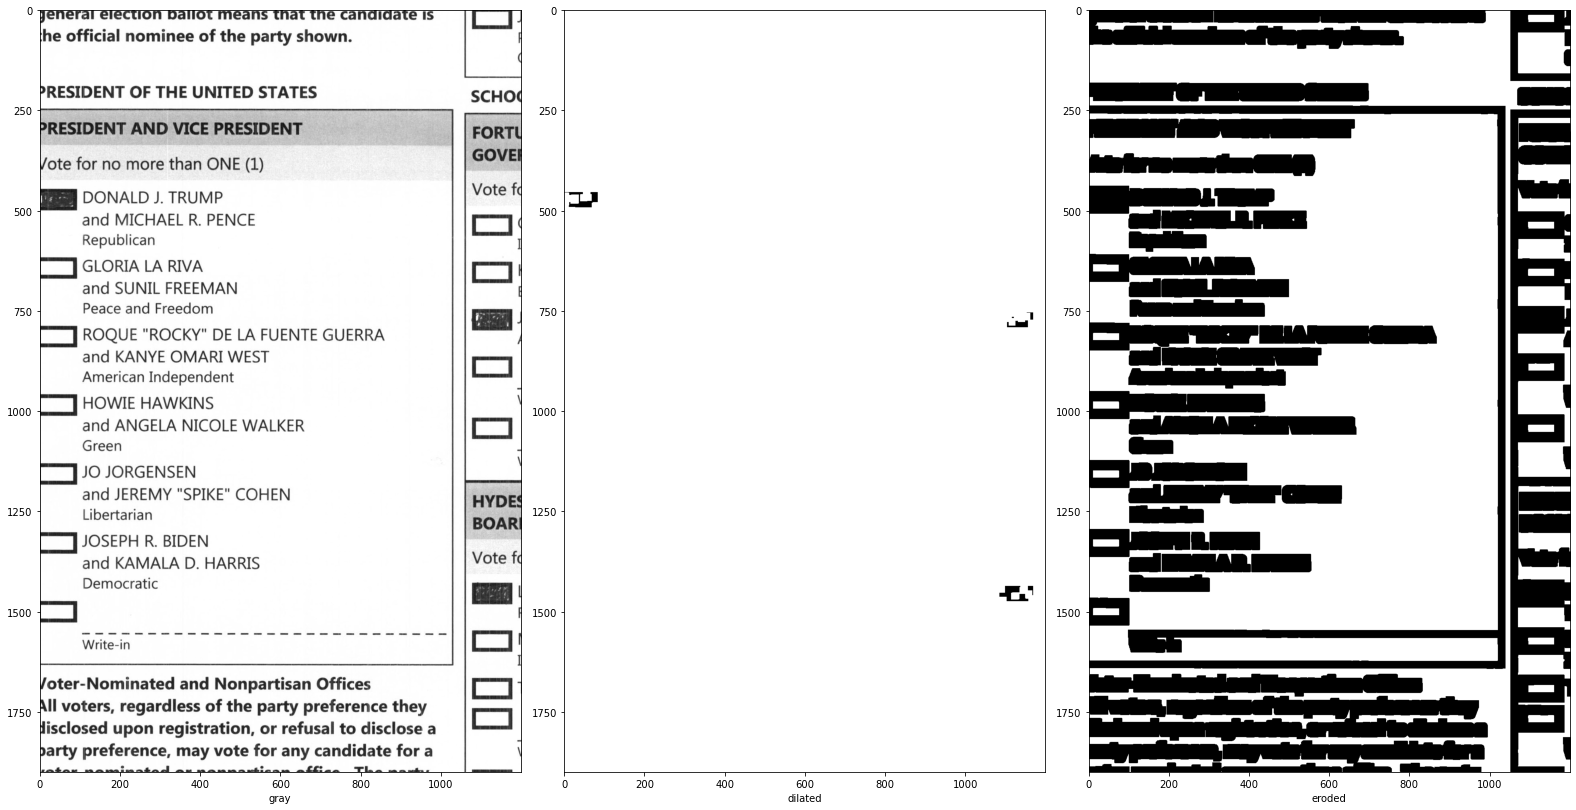

In [39]:
subset = template[900:2800, 300:1500]

#kernel = np.zeros((15,15),np.uint8)
subset_gray = cv2.cvtColor(subset, cv2.COLOR_BGR2GRAY)
#subset_binary = cv2.threshold(subset_gray, 127, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
subset_binary = cv2.threshold(subset_gray, 127, 255,cv2.THRESH_OTSU)[1]

se = cv2.getStructuringElement(cv2.MORPH_RECT,(9,9),(-1,-1))
subset_dilated = cv2.dilate(subset_binary,se,iterations = 2)
subset_eroded = cv2.erode(subset_binary,se,iterations = 2)

debug_display_images((subset_gray,'gray'),(subset_dilated,'dilated'), (subset_eroded,'eroded'))

In [6]:
#align form to template
#fake BallotScanner needed
#bs = BallotScanner(path_to_metadata_dir, template_dir_path, path_to_logfile)
@dataclass
class Fake:  #v1.5 changes
    form_path: str = ""

bs = Fake()
bs.form_path = form_path  #monkey patch

img_reg, M, message, final_choices_dict = align_form_and_update_CB_locations(form, template, choices, bs)

entered align_form 3
found 3512 comtours
contour matching found 21 CB on ballot
choices dict has 24 CB to be updated
closest distance 77.02596964660685 was too far - contours can't map #0
closest distance 77.02596964660685 was too far - contours can't map #0
closest distance 77.02596964660685 was too far - contours can't map #0
closest distance 77.02596964660685 was too far - contours can't map #0
closest distance 77.02596964660685 was too far - contours can't map #0
closest distance 77.02596964660685 was too far - contours can't map #0
closest distance 76.05918747922567 was too far - contours can't map #15
closest distance 76.05918747922567 was too far - contours can't map #15
closest distance 76.05918747922567 was too far - contours can't map #15
closest distance 76.05918747922567 was too far - contours can't map #15
closest distance 76.05918747922567 was too far - contours can't map #15
closest distance 76.05918747922567 was too far - contours can't map #15
closest distance 76.05918

AttributeError: 'Fake' object has no attribute 'metadata'

In [ ]:
M

In [ ]:
choices

In [ ]:

def measure_extraneous_marking(contest, form):
    #define a standard area around the choiceboxes, extract from image and invert to binary
    # measure total marking (anything white, including text and lines)
    # substract what's inside each CB
    # substract template's baseline for this same contest (precinct, page, etc)
    # return as percent marked compared to total area of contest
    #
    #assumes contest is all in one column!!

    #define area and extract from image

    #fixme - these assumptions aren't transportable to other form designs
    #have to be same as used in template baseline
    #assumes fully aligned and homologized forms
    CONTEST_MARKS_LEFT_EDGE_FROM_CX = 60
    CONTEST_MARKS_COLUMN_WIDTH = 1020
    CONTEST_MARKS_BOTTOM_EDGE_BELOW_CY = 124
    CONTEST_MARKS_TOP_EDGE_ABOVE_CY = 37

    #find the choice boxes for this contest, and isolate the top and bottom choices
    contest_boxes = [cb for cb in contest['choice_boxes']]
    sorted_boxes = sorted(contest_boxes, key=lambda cb:cb['cY'] ) #sorts ascending by cY
    top_box = sorted_boxes[0]
    bottom_box = sorted_boxes[-1]
    
    #extract a subset of the image based on offsets from top and bottom choices

    left_x = top_box['cX'] - CONTEST_MARKS_LEFT_EDGE_FROM_CX
    top_y = top_box['cY'] - CONTEST_MARKS_TOP_EDGE_ABOVE_CY
    right_x = left_x + CONTEST_MARKS_COLUMN_WIDTH 
    bottom_y = bottom_box['cY'] + CONTEST_MARKS_BOTTOM_EDGE_BELOW_CY
    
    #first cut - clip a large area that contains more than we want
    #image is rows, cols -> y, x
    contest_img = form[top_y:bottom_y, left_x:right_x, : ].copy()

    #binary and invert
    contest_gray = cv2.cvtColor(contest_img, cv2.COLOR_BGR2GRAY)
    contest_binary = cv2.threshold(contest_gray, 127, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

    #find total non-black
    total_marks = cv2.countNonZero(contest_binary)

    #substract any marks inside checkboxes (we only want the outside stuff)

    for cb in contest['choice_boxes']:
        offset_cX = cb['cX'] - left_x
        offset_cY = cb['cY'] - top_y
        ul_x, ul_y, lr_x, lr_y = calc_choice_box_scoring_coords(offset_cX, offset_cY )
        cb_area = contest_binary[ul_y:lr_y, ul_x:lr_x] #do I need +1?
        cb_score = cv2.countNonZero(cb_area)
        print(f"CB {cb['candidate']} has score {cb_score}")
        total_marks -= cb_score

    #
    pc = total_marks / ((bottom_y - top_y) * (right_x - left_x))
    print(f"Contest: {contest['contest_name']} has score of {total_marks} percentage: {pc}")
    if pc > 0.03:
        plt.imshow(contest_binary, cmap='gray')    
        plt.show()

    return

In [ ]:
contest_name = "SUPERVISOR DISTRICT 2"
contests = choices['contests']
for contest in contests:
    if contest['contest_name'] == contest_name:
        break

measure_extraneous_marking(contest, img_reg)